In [1]:
import pandas as pd
import numpy as np
import sklearn
from coleta_de_dados import Dataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/guaxim/Projetos/tosh/ai/anomaly-detection/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from preprocessamento import Preprocessing
pp = Preprocessing()
df,faultydf = pp.normal, pp.anomalos[0]
#ja sabemos que nao ha na


Filtro Savitzky-Golay aplicado em 9 colunas
Filtro Savitzky-Golay aplicado em 9 colunas

Fazendo Resampling e Interpolate de IMU_10Hz.csv
Buracos gerados pelo alinhamento: 44766
Resampling concluído. Novo shape: (876347, 10)

Fazendo Resampling e Interpolate de IMU_hitting_platform.csv
Buracos gerados pelo alinhamento: 900
Resampling concluído. Novo shape: (14992, 10)


In [3]:
df = df.drop(columns=["time"])
faultydf = faultydf.drop(columns=["time"])
print(df.columns)
df.describe()

Index(['accX', 'magX', 'accZ', 'magZ', 'gyroX', 'gyroY', 'gyroZ', 'accY',
       'magY'],
      dtype='object')


,accX,magX,accZ,magZ,gyroX,gyroY,gyroZ,accY,magY
count,876347.000000,876347.000000,876347.000000,876347.000000,876347.000000,876347.000000,876347.000000,876347.000000,876347.000000
mean,9.268961,-33.343919,0.495058,-2.487155,0.347984,0.666203,0.030966,-0.680065,19.585614
std,1.490053,5.834655,0.194301,31.452172,27.965121,8.069170,26.261000,3.074355,19.271217
min,1.377489,-51.190000,-0.381052,-59.278847,-82.626953,-28.013672,-94.050781,-9.774553,-48.592500
25%,9.475876,-35.966250,0.398485,-35.576923,-4.162109,-0.439453,-3.201172,-0.615684,14.682500
50%,9.860594,-35.192500,0.498967,6.658654,-0.027344,-0.015625,-0.027344,-0.033818,30.241250
75%,9.949329,-32.292499,0.569072,17.641827,1.326172,0.201172,1.384766,0.205602,30.858750
max,11.125257,-8.641250,1.393874,52.151443,90.914062,51.025391,106.115234,8.312219,40.875000


In [4]:
#separar manualmente e sem shuffling para nunca treinar com dados futuros
def _train_test_split(df:pd.DataFrame, trainPer=0.6,valPer=0.2, testPer=0.2):
    assert(trainPer + valPer + testPer <= 1.0)

    size = df.shape[0]

    traindf = df.iloc[:int(size*trainPer)]
    valdf = df.iloc[int(size*trainPer)  : int(size*(valPer + trainPer))  ] 
    testdf = df.iloc[int(size*(valPer+ trainPer)): ] 
    return traindf,valdf,testdf

def __show_splitting(train, val, test,expectedTotal):
    total = train.shape[0] + val.shape[0] + test.shape[0]
    assert(total == expectedTotal)
    
    # Calculate percentages
    pcts = (np.array([[len(train), len(val), len(test)]]) / total) * 100
    
    # FIX: Pass a list of 3 separate strings for the 3 columns
    ddf = pd.DataFrame(
        pcts.round(2),
        columns=["Train %", "Val %", "Test %"] 
    )
    print(ddf)


X_train, X_val,X_test = _train_test_split(df)
__show_splitting(X_train,X_val,X_test, df.shape[0])

_, anom_val,anom_test = _train_test_split(faultydf,trainPer=0,valPer=0.40,testPer=0.6)
__show_splitting(_,anom_val,anom_test, faultydf.shape[0])


X_train = X_train
X_val = X_val
X_test = X_test
anom_val = anom_val
anom_test = anom_test


   Train %  Val %  Test %
0     60.0   20.0    20.0
   Train %  Val %  Test %
0      0.0  39.99   60.01


## Engenharia de features em janelas
Essa parte só vai ser usada pros modelos probabilísticos e de clustering. O de deep learning usará apenas janelas comuns

In [5]:
from scipy.stats import kurtosis, skew
def add_point_engineered_features(df:pd.DataFrame) -> pd.DataFrame:
    #add point only features
    # sens_jerk e sens_norm
    sensors = "acc gyro mag".split(' ')
    df = df.copy()
    # for sensAxis in base_features:
    #     df[f"{sensAxis}_jerk"] = df[sensAxis].diff()
    #jerk removido por variância irrisória
    for sens in sensors:
        df[f"{sens}_norm"] = np.sqrt(df[f"{sens}X"]**2 + df[f"{sens}Y"]**2 + df[f"{sens}Z"]**2)

    return df
def make_windows(df, length, overlap, drop_incomplete=True):
    arr = df.values  # (T, C)
    step = length - overlap
    n = arr.shape[0]

    stops = n - length + 1 if drop_incomplete else n
    starts = range(0, stops, step)

    windows = []
    for s in starts:
        w = arr[s:s + length]
        if w.shape[0] == length:
            windows.append(w)

    return np.stack(windows, axis=0)  # (N_windows, L, C)


def window_feature_engineering(windows, feature_names, stats=("mean", "std", "ptp", "kurtosis", "crest", "dom_freq")):
    """
    Extracts statistical features from time-series windows for traditional ML models.
    
    Args:
        windows (np.array): Shape (N_samples, Window_Size, N_sensors)
        feature_names (list): List of sensor names strings (e.g., ['accX', 'accY'...])
        stats (tuple): List of stats to compute.
    
    Returns:
        X_feat (np.array): Shape (N_samples, N_features)
        names (list): List of feature names
    """
    feats = []
    names = []
    
    # 1. Mean (General Position/Bias)
    if "mean" in stats:
        feats.append(np.mean(windows, axis=1))
        names += [f"mean_{c}" for c in feature_names]

    # 2. Standard Deviation (Vibration Energy)
    if "std" in stats:
        feats.append(np.std(windows, axis=1))
        names += [f"std_{c}" for c in feature_names]

    # 3. RMS (Total Energy - redundancy with Mean/Std, but useful for physics)
    if "rms" in stats:
        rms = np.sqrt(np.mean(windows**2, axis=1))
        feats.append(rms)
        names += [f"rms_{c}" for c in feature_names]

    # 4. Peak-to-Peak (Amplitude of Shocks - critical for Bumps)
    if "ptp" in stats:
        feats.append(np.ptp(windows, axis=1))
        names += [f"ptp_{c}" for c in feature_names]

    # 5. Kurtosis (Impulsiveness - critical for Hits/Earthquakes)
    if "kurtosis" in stats:
        # Fisher=False makes normal distribution = 3.0. 
        # Often easier to use Fisher=True (normal = 0.0) for ML centering.
        k = kurtosis(windows, axis=1, fisher=True) 
        feats.append(k)
        names += [f"kurt_{c}" for c in feature_names]

    # 6. Skewness (Asymmetry - useful for directional crashes)
    if "skew" in stats:
        s = skew(windows, axis=1)
        feats.append(s)
        names += [f"skew_{c}" for c in feature_names]

    # 7. Crest Factor (Impact Indicator - Peak / RMS)
    if "crest" in stats:
        peak = np.max(np.abs(windows), axis=1)
        rms = np.sqrt(np.mean(windows**2, axis=1))
        # Add small epsilon to avoid division by zero
        crest = peak / (rms + 1e-9) 
        feats.append(crest)
        names += [f"crest_{c}" for c in feature_names]
        
    # 8. Dominant Frequency (Resonance - useful for Heavy Weight detection)
    if "dom_freq" in stats:
        # Perform FFT along the time axis (axis 1)
        fft_vals = np.fft.rfft(windows, axis=1)
        fft_freq = np.fft.rfftfreq(windows.shape[1])
        
        # Find index of max magnitude (ignoring DC component at index 0)
        magnitudes = np.abs(fft_vals)
        magnitudes[:, 0, :] = 0  # Zero out DC component
        
        dom_indices = np.argmax(magnitudes, axis=1) # Shape (N, C)
        
        # Map indices to actual frequencies
        dom_freqs = fft_freq[dom_indices]
        
        feats.append(dom_freqs)
        names += [f"domfreq_{c}" for c in feature_names]

    X_feat = np.concatenate(feats, axis=1)  # (N, Total_Features)
    return X_feat, names

In [6]:
"""point egnheirada"""
def feature_engineering_pipeline(ds):
    #somente do ponto
    ds_pe = add_point_engineered_features(ds)

    # ---- windowing ----
    WINDOW_SIZE = 40
    WINDOW_OVERLAP = 10

    ds_w = make_windows(ds_pe, WINDOW_SIZE, WINDOW_OVERLAP)

    #somente da janela
    ds_feat, feat_names = window_feature_engineering(
        ds_w,
        feature_names=ds_pe.columns,
        )
    return ds_feat, feat_names

X_train_feat,feat_names  = feature_engineering_pipeline(X_train)
X_val_feat,_    = feature_engineering_pipeline(X_val)
X_test_feat,_   = feature_engineering_pipeline(X_test)

anom_val_feat,_ = feature_engineering_pipeline(anom_val)
anom_test_feat,_= feature_engineering_pipeline(anom_test)
print(X_train_feat.shape) 
print(feat_names)         


(17526, 72)
['mean_accX', 'mean_magX', 'mean_accZ', 'mean_magZ', 'mean_gyroX', 'mean_gyroY', 'mean_gyroZ', 'mean_accY', 'mean_magY', 'mean_acc_norm', 'mean_gyro_norm', 'mean_mag_norm', 'std_accX', 'std_magX', 'std_accZ', 'std_magZ', 'std_gyroX', 'std_gyroY', 'std_gyroZ', 'std_accY', 'std_magY', 'std_acc_norm', 'std_gyro_norm', 'std_mag_norm', 'ptp_accX', 'ptp_magX', 'ptp_accZ', 'ptp_magZ', 'ptp_gyroX', 'ptp_gyroY', 'ptp_gyroZ', 'ptp_accY', 'ptp_magY', 'ptp_acc_norm', 'ptp_gyro_norm', 'ptp_mag_norm', 'kurt_accX', 'kurt_magX', 'kurt_accZ', 'kurt_magZ', 'kurt_gyroX', 'kurt_gyroY', 'kurt_gyroZ', 'kurt_accY', 'kurt_magY', 'kurt_acc_norm', 'kurt_gyro_norm', 'kurt_mag_norm', 'crest_accX', 'crest_magX', 'crest_accZ', 'crest_magZ', 'crest_gyroX', 'crest_gyroY', 'crest_gyroZ', 'crest_accY', 'crest_magY', 'crest_acc_norm', 'crest_gyro_norm', 'crest_mag_norm', 'domfreq_accX', 'domfreq_magX', 'domfreq_accZ', 'domfreq_magZ', 'domfreq_gyroX', 'domfreq_gyroY', 'domfreq_gyroZ', 'domfreq_accY', 'domfreq

### Seleção de features

sobraram 72 vars. Removemos 0 features de baixa variância:
[]


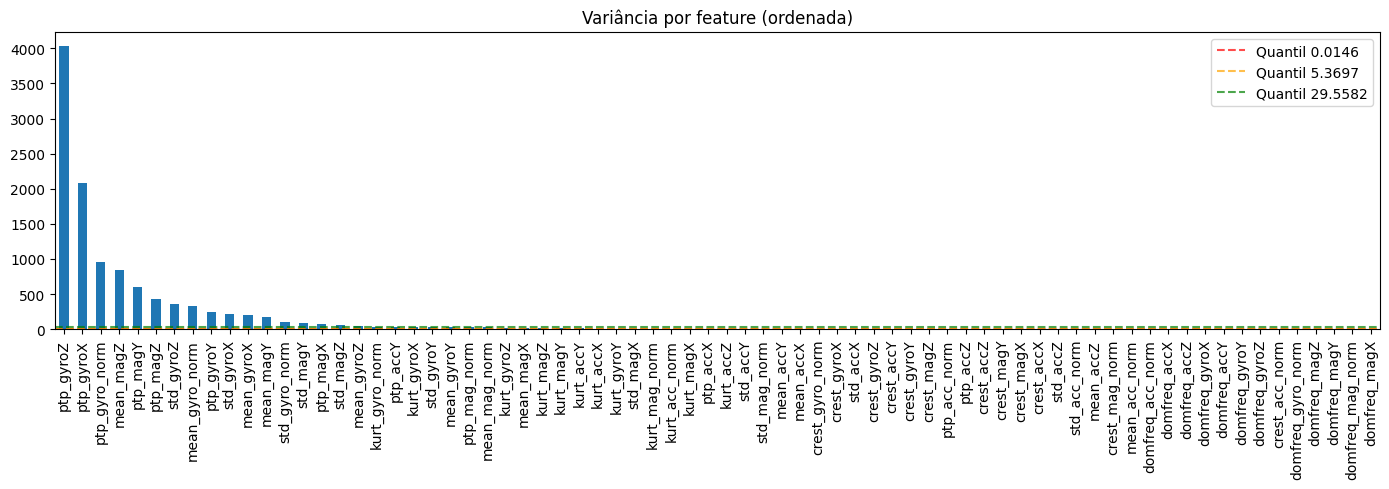

                 0
count    72.000000
mean    155.001337
std     550.214023
min       0.000367
25%       0.014574
50%       5.369662
75%      29.558235
max    4033.937085
['ptp_gyroZ:4033.9371', 'ptp_gyroX:2085.5581', 'ptp_gyro_norm:951.1148', 'mean_magZ:842.0358', 'ptp_magY:598.8409', 'ptp_magZ:425.5211', 'std_gyroZ:359.5529', 'mean_gyro_norm:326.0310', 'ptp_gyroY:238.8529', 'std_gyroX:215.8509', 'mean_gyroX:206.1885', 'mean_magY:176.2995', 'std_gyro_norm:98.7970', 'std_magY:84.4533', 'ptp_magX:77.6072', 'std_magZ:63.3353', 'mean_gyroZ:47.5656', 'kurt_gyro_norm:31.1777', 'ptp_accY:29.0184', 'kurt_gyroX:27.5093', 'std_gyroY:27.4599', 'mean_gyroY:25.8445', 'ptp_mag_norm:25.7239', 'mean_mag_norm:23.7100', 'kurt_gyroZ:15.3699', 'mean_magX:13.8658', 'kurt_magZ:12.2328', 'kurt_magY:11.5508', 'kurt_accY:10.1320', 'kurt_accX:9.1330', 'kurt_gyroY:8.6559', 'std_magX:8.6339', 'kurt_mag_norm:8.5798', 'kurt_acc_norm:6.6471', 'kurt_magX:6.5660', 'ptp_accX:6.5291', 'kurt_accZ:4.2103', 'std_accY:4.02

In [7]:
var = X_train_feat.var(axis=0)

VAR_EPS = 1e-5
keep_var = var > VAR_EPS

X_train_feat_var = X_train_feat[:, keep_var]
feat_names_var = [n for n, k in zip(feat_names, keep_var) if k]

print(f"sobraram {np.count_nonzero(keep_var)} vars. Removemos {np.sum(~keep_var)} features de baixa variância:\n{sorted(set(feat_names) - set(feat_names_var))}")


# variância por feature e linhas de quantis
# ordenar pela variância (NaNs vão para o final)
#normalizar apenas pra visualização
from sklearn.preprocessing import MinMaxScaler
varNorm = var 
var_series = pd.Series(varNorm, index=feat_names).sort_values(ascending=False)

ax = var_series.plot(kind="bar", figsize=(14, 5), title="Variância por feature (ordenada)")

# quantis (25%, 50%, 75%)
quantiles = np.nanquantile(varNorm, [0.25, 0.5, 0.75])
for q, color in zip(quantiles, ["red", "orange", "green"]):
    ax.axhline(q, color=color, linestyle="--", alpha=0.7, label=f"Quantil {q:.4f}")

# seta para indicar features removidas (ex.: primeiro removido)


ax.legend()
plt.tight_layout()
plt.show()

#pd.DataFrame(X_train_feat_var, columns=feat_names_var).describe()
print(pd.DataFrame(var).describe())
print([f"{name}:{float(var):.4f}" for var,name in sorted(zip(var, feat_names), key=lambda x: x[0], reverse=True)])

In [8]:
corr = np.corrcoef(X_train_feat_var, rowvar=False)

CORR_TH = 0.95
to_drop = set()

for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if abs(corr[i, j]) > CORR_TH:
            to_drop.add(j)  

keep_corr = [i not in to_drop for i in range(corr.shape[0])]

X_train_feat_sel = X_train_feat_var[:, keep_corr]
feat_names_sel = [n for n, k in zip(feat_names_var, keep_corr) if k]

print(f"Remaining features: {len(feat_names_sel)}\n:{feat_names_sel}")


Remaining features: 58
:['mean_accX', 'mean_magX', 'mean_accZ', 'mean_magZ', 'mean_gyroX', 'mean_gyroY', 'mean_gyroZ', 'mean_accY', 'mean_magY', 'mean_acc_norm', 'mean_gyro_norm', 'mean_mag_norm', 'std_accX', 'std_magX', 'std_accZ', 'std_magZ', 'std_gyroX', 'std_gyroY', 'std_gyroZ', 'std_magY', 'std_acc_norm', 'std_gyro_norm', 'std_mag_norm', 'kurt_accX', 'kurt_magX', 'kurt_accZ', 'kurt_magZ', 'kurt_gyroX', 'kurt_gyroY', 'kurt_gyroZ', 'kurt_accY', 'kurt_magY', 'kurt_acc_norm', 'kurt_gyro_norm', 'kurt_mag_norm', 'crest_magX', 'crest_accZ', 'crest_magZ', 'crest_gyroX', 'crest_gyroY', 'crest_gyroZ', 'crest_accY', 'crest_magY', 'crest_acc_norm', 'crest_gyro_norm', 'crest_mag_norm', 'domfreq_accX', 'domfreq_magX', 'domfreq_accZ', 'domfreq_magZ', 'domfreq_gyroX', 'domfreq_gyroY', 'domfreq_gyroZ', 'domfreq_accY', 'domfreq_magY', 'domfreq_acc_norm', 'domfreq_gyro_norm', 'domfreq_mag_norm']


In [9]:
def apply_feature_mask(X_feat, mask):
    return X_feat[:, mask]
final_mask = keep_var.copy()
final_mask[keep_var] = keep_corr

Vemos que não foram removidas features devido a baixa variância, mas a análise de correlação foi frutífera.

### Redução da dimensionalidade
Reduzir a dimensinoalidade com PCA, pois mesmo 58 features ainda é bastante para clustering, por exemplo.

In [10]:
def PCA_normalize(X_train_masked, X_val_masked=None, X_test_masked=None, variance_threshold=0.95):
    """
    Faz scaling e PCA nos splits. recebe os datasets ja somente com as features usadas
    """

    
    # 1. Standardize (Crucial for PCA)
    # We use StandardScaler because PCA seeks to maximize variance. 
    # If using GMM later, the output of PCA is naturally centered, which is fine.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_masked)
    
    # 2. Fit PCA
    pca = PCA(n_components=variance_threshold)
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    print(f"PCA:")
    print(f"  - Features antes : {X_train_masked.shape[1]}")
    print(f"  - Features após: {X_train_pca.shape[1]}")
    print(f"  - Variância explicada: {np.sum(pca.explained_variance_ratio_):.4f}")

    # 3. Transform Validation/Test sets if provided
    X_val_pca = None
    X_test_pca = None
    
    if X_val_masked is not None:
        X_val_scaled = scaler.transform(X_val_masked)
        X_val_pca = pca.transform(X_val_scaled)
        
    if X_test_masked is not None:
        X_test_scaled = scaler.transform(X_test_masked)
        X_test_pca = pca.transform(X_test_scaled)

    return pca, scaler, X_train_pca, X_val_pca, X_test_pca
a,b,c = X_train_feat[:, final_mask], X_val_feat[:, final_mask], X_test_feat[:, final_mask]
pca, scaler, X_train_pca, X_val_pca, X_test_pca = PCA_normalize(
    a, b, c, variance_threshold=0.95)

anom_val_pca = pca.transform(scaler.transform(anom_val_feat[:, final_mask]))
anom_test_pca = pca.transform(scaler.transform(anom_test_feat[:, final_mask]))




PCA:
  - Features antes : 58
  - Features após: 29
  - Variância explicada: 0.9501


In [13]:
#EXEMPLO APENAS

from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

iso = IsolationForest(
    n_estimators=200,
    contamination="auto",
    random_state=42,
    n_jobs=-1,
)
iso.fit(X_train_pca)

def evaluate_split(X_norm, X_anom, clf, split_name):
    X = np.vstack([X_norm, X_anom])
    y = np.hstack([np.zeros(len(X_norm)), np.ones(len(X_anom))])  # 0=normal, 1=anomalia

    y_pred = clf.predict(X)
    y_pred = (y_pred == -1).astype(int)  # -1 é anomalia no IF

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    print(f"{split_name} -> acc: {acc:.3f} | prec: {prec:.3f} | rec: {rec:.3f} | f1: {f1:.3f}")

evaluate_split(X_val_pca, anom_val_pca, iso, "Validação")
evaluate_split(X_test_pca, anom_test_pca, iso, "Teste")


Validação -> acc: 0.912 | prec: 0.267 | rec: 0.950 | f1: 0.416
Teste -> acc: 0.908 | prec: 0.342 | rec: 0.970 | f1: 0.506


In [20]:
X_train_pca.shape,anom_test_pca.shape

((17526, 29), (299, 29))